In [7]:
#%%
# path to working directory
path = '/Users/davidnordfors/galvanize/galvanize-capstone/final'

# IMPORT LIBRARIES
## OS
import os
os.chdir(path)

# MANAGE
import pandas as pd
import numpy as np
#from collections import Counter
from boolma import BM
## FIT
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

## DECOMPOSITION
from sklearn.decomposition import NMF
from scipy.linalg import svd

## GRAPHICS
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

def dist_boxplot(x, **kwargs):
    ax = sns.distplot(x, hist_kws=dict(alpha=0.2))
    ax2 = ax.twinx()
    sns.boxplot(x=x, ax=ax2)
    ax2.set(ylim=(-5, 5))


#%% DATA
## I/O
import zipfile
import requests
import pickle

# Normalization function
def norm(vec):
    return (vec-vec.mean())/vec.std()

# READ O*NET DATABASE. Search order: Dictionary, Pickle, Excel; Create dictionary/pickle if non-existent.
onet = {}
def from_onet(qualities):
        if qualities in onet:
                return onet[qualities]
        pickle_exists = os.path.isfile('./data/pickle/'+qualities+'.pkl')
        if pickle_exists:
                onet[qualities] = pd.read_pickle('./data/pickle/'+qualities+'.pkl')
                return onet[qualities]
        else: 
                onet[qualities]= pd.read_excel(
                        zipfile.ZipFile('./data/db_23_2_excel.zip').extract(
                        'db_23_2_excel/'+qualities+'.xlsx'))
                onet[qualities].to_pickle('./data/pickle/'+qualities+'.pkl')
                return onet[qualities]


# format and Strip O*NET SOC occupation codes to match the ones used by Census PUMS

# def soc(socc):
#     code = str(socc).replace('-','')
#     return code[:6]

def soc(socc):
    code = str(socc).replace('-','')
    return code[:5]


# CENSUS DATA: 
#%% PUMS Data dictionary
#Source: https://www.census.gov/programs-surveys/acs/data/pums.html )
datadic = pd.read_csv("./data/PUMS_Data_Dictionary_2017.csv").drop_duplicates()

# rows including the string 'word'
def var_about(word):
    return pd.concat((BM(datadic).select('Record Type', 'contains',word).df,
                      BM(datadic).select('Unnamed: 6', 'contains',word).df))

# Name of occupation for SOCP number
def socp_name(socc):
    return datadic[datadic['Record Type']== str(socc)]['Unnamed: 6'].values[0]

tits = from_onet('Alternate Titles')
all_SOCP = set(tits['O*NET-SOC Code'])


# def lookup_title(socc):
#     soccn = socc[:2]+'-'+socc[2:]+'.00'
#     if soccn in all_SOCP:
#         return tits[tits['O*NET-SOC Code']== soccn].iloc[0].get('Title')
#     else:
#         return 'NaN'

aaa = tits[['O*NET-SOC Code','Title']]
aaa['O*NET-SOC Code'] = aaa['O*NET-SOC Code'].apply(soc)
looktit = dict(aaa.values)
def lookup_title(socpnr):
    return looktit[socpnr]

        
#%% select workers in ages 40 - 65 and discard the occupations with large standard deviations.
all_workers = pd.read_pickle('data/pickle/pums_California.pkl')
workers = BM(all_workers).select(
            'AGEP','gt',40).select(
            'AGEP','lt',65).df
workers['log FTE'] = workers['FTE wage'].apply(np.log)
workers['SOCP_shave'] = workers['SOCP'].apply(soc)

foo = workers.groupby('SOCP_shave') 
all_occupations = foo.mean()[['AGEP', 'FTE wage','log FTE']]
all_occupations['count'] = foo.count()['AGEP']
all_occupations['std log FTE'] = foo.std()['log FTE']
all_occupations['SOCP'] = all_occupations.index
all_occupations['SOCP_shave'] = all_occupations['SOCP'].apply(soc)
all_occupations['Occupation'] = all_occupations['SOCP_shave']
occupations = all_occupations[all_occupations['std log FTE']<0.50]

#%%  CREATE X:features from O*NET; and y: mean wages from census/pums

def matrix(features):
    # Build X: occupation/feature matrix from O*NET
    foo = pd.get_dummies(features['Element Name']) 
    occ_features = features[['O*NET-SOC Code']].join(foo.multiply(features['Data Value'],axis = "index")).groupby('O*NET-SOC Code').sum()
    occ_features['SOCP'] = occ_features.index
    occ_features['SOCP_shave']=occ_features['SOCP'].apply(soc)
    # Group by census/PUMS SOC codes (SOCP_shave)
    occ_features_compounded= occ_features.groupby('SOCP_shave').mean()
    occ_features_compounded['SOCP_shave'] = occ_features_compounded.index   
    foo = occ_features_compounded.drop(columns='SOCP_shave')
    return foo

def xy(features,occupations):
    #Normalizes occupation matrix
    #foo = matrix(features)
    foo = features
    occ_features_norm = (foo - foo.mean())/foo.std()
    

    # Normalize y:  Census/PUMS log FTE wages   
    foo = occupations[['SOCP_shave','Occupation','FTE wage','log FTE']].copy()
    foo['log FTE'] =norm(occupations['log FTE'])

    # Merge and align X & y for occupations
    fit_data = foo.merge(occ_features_norm,left_on='SOCP_shave',right_index=True)
    
    # Return X & y
    y = fit_data['log FTE']
    X = fit_data.drop(columns = ['SOCP_shave', 'Occupation', 'FTE wage', 'log FTE'])
    return (X,y)


    # Normalize y:  Census/PUMS log FTE wages   
    foo = occupations[['SOCP_shave','Occupation','FTE wage','log FTE']].copy()
    foo['log FTE'] =norm(occupations['log FTE'])

    # Merge and align X & y for occupations
    fit_data = foo.merge(occ_features_norm,left_on='SOCP_shave',right_index=True)
    
    # Return X & y
    y = fit_data['log FTE']
    X = fit_data.drop(columns = ['SOCP_shave', 'Occupation', 'FTE wage', 'log FTE'])
    return (X,y)


# SELECT FEATURE SETS FROM O*NET, FIT FOR O*NET FTE WAGES 

# Prepare feature sets.
def prepare(df):
    # For Abilities, Knowledge, Skills
    if 'LV' in set(df['Scale ID']):
        sid = 'LV'
    # For Interests
    elif 'OI' in set(df['Scale ID']):
        sid = 'OI'
    df = df[df['Scale ID'] == sid]

    return df[['O*NET-SOC Code','Element Name','Data Value']]

   

dab = prepare(from_onet('Abilities'))
dkn = prepare(from_onet('Knowledge'))
dsk = prepare(from_onet('Skills'))
din = prepare(from_onet('Interests'))

dwa = prepare(from_onet('Work Activities'))
dwv = from_onet('Work Values')
dwv = dwv[dwv['Scale Name'] == 'Extent'][['O*NET-SOC Code','Element Name','Data Value']]

ded =from_onet('Education, Training, and Experience')
ded['catval'] = ded['Category'] * ded['Data Value']
SOCP_all = ded['O*NET-SOC Code'].unique()
aaa = pd.DataFrame()
for soccno in SOCP_all:
    bbb = ded[ded['O*NET-SOC Code'] == soccno]
    ccc = bbb.groupby('Element Name').sum()
    ccc['Data Value'] = ccc['catval']/ccc['Data Value']
    ccc['O*NET-SOC Code'] = soccno
    aaa = pd.concat([aaa,ccc])
dedd = aaa.reset_index().dropna()

featurenames = ['Abilities','Knowledge','Skills','Interests']

# Put them all together in one big feature matrix
dall = pd.concat([matrix(dab),
                  matrix(dsk),
                  matrix(dkn),
                 # matrix(din),
                 # matrix(dwa),
                 # matrix(dwv),
                 # matrix(dedd)
                 ],axis = 1).dropna()

#%% MODEL & FIT

# CLUSTER FEATURES INTO OCCUPATION CATEGORIES
# Use non-zero matrix factorization for clustering
# Use singular value decomposition first state for determining overall similarity


class OnetCluster:
    def __init__(self,X,n):
        self.X = X
        self.model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000, tol = 0.0000001)
        self.w = self.model.fit_transform(X)
        self.o = pd.DataFrame(self.w,index=X.index)
        self.on = nrmcol(self.o.T).T
        self.h = self.model.components_
        self.f = pd.DataFrame(self.h,columns=X.columns)
        self.fn = nrmcol(self.f.T).T
    


class Svd:
    def __init__(self,X):
        self.u,self.s,self.vt = svd(np.array(X))
        self.f = pd.DataFrame(self.vt,columns=X.columns)
        self.o = pd.DataFrame(self.u,columns=X.index)
        
def nrmcol(df):
    return df / np.sqrt(np.diagonal(df.T @ df))


#Select PUMS data for occupations in an OnetCluster. 
#Default threshold set to 0.7: only occupations with at least 0.49 of their weight in the cluster are included. 

def clocc(n_order,m_cluster,thresh = 0.7):
    soccs = clcat[n_order][m_cluster][clcat[n_order][m_cluster] > thresh]
    cloccs = soccs.merge(occupations,left_index=True, right_index=True).dropna()
    return cloccs


# Create the matrix of all features




reg_ridge = linear_model.Ridge(alpha=.5)
rf = RandomForestRegressor(n_estimators=40,
                           max_features='auto',
                           random_state=0)

featuresets = [OnetCluster(dall,i).o for i in [6]]

# Xt={}
# yt = {}
# test_fit={}
# coefs = {}
# for ft in range(len(featuresets)):
#     test_fit[ft] = {}
#     coefs[ft] = {}
#     X, y = xy(featuresets[ft],occupations)
#     for sed in range(500):      
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#         Xt[ft],yt[ft]=X_test,y_test
#         res = cross_validate(reg_ridge,X_train, y_train, cv=3, return_estimator=True)
#         #res = cross_validate(rf,X_train, y_train, cv=n, return_estimator=True)
#         #res = cross_validate(lasse,X_train, y_train, cv=n, return_estimator=True)
#         test_fit[ft][sed]= [res['estimator'][j].score(X_test,y_test) for j in range(3)]
#         coefs[ft][sed]= np.array([res['estimator'][j].coef_ for j in range(3)])
#     coefs[ft]['pd'] = pd.DataFrame(np.concatenate(np.array(list(coefs[ft].values()))))



# # The coefficients for the n'th featureset fitted above
# def coefficients(n):
#     return pd.DataFrame([coefs[n]['pd'].mean(),coefs[n]['pd'].std()],index=['mean','std']).T.sort_values('mean',ascending=False)

# # In the example above we have only one featureset: OnetCluster(dall,6)
# # The entire featurespace has been reduced to 6 dimensions, by NMF clustering
# resfeat = coefficients(0).merge(OnetCluster(dall,6).fn,left_index=True,right_index=True)
# result_features = {}
# for i in range(len(resfeat)):
#     result_features[i] = resfeat.iloc[i].sort_values(ascending=False)[:10]

# aaa = OnetCluster(dall,6)
# bbb = aaa.on.copy()
# bbb['SOCP_shave'] = bbb.index
# bbb['Title'] = bbb['SOCP_shave'].apply(lookup_title)
# aaa.ont = bbb
# ccc = aaa.ont.set_index(aaa.ont['Title'])
# resocc = coefficients(0).merge(ccc.T,left_index=True,right_index=True)

# result_occupations = {}
# for i in range(len(result_occupations)):
#     result_occupations[i] = resocc.iloc[i].sort_values(ascending=False)[:10]


# # The 6 coefficient/dimension correspond to the 6 occupation/feature clusters
# # Functions for looking at the clusters:


def plf(dd,n):
    sns.clustermap(OnetCluster(matrix(dd),n).fn.apply(lambda x: x**2).sort_values(
    1,axis=1,ascending = False).T,figsize=(2*n, 16),method = 'single')

def plo_sort(feature_set,order,topic,sort,thresh=0.5):
    return BM(plo(feature_set,order)).select(topic,'gt',thresh).df[[topic,'Title','FTE wage','count']].sort_values(sort,ascending = False)

def plo_fte(feature_set,order,topic,thresh=0.5):
    return BM(plo(feature_set,order)).select(topic,'gt',thresh).df[[topic,'Title','FTE wage','count']].sort_values('FTE wage',ascending = False)

def plo_count(feature_set,order,topic,thresh=0.5):
    return BM(plo(feature_set,order)).select(topic,'gt',thresh).df[[topic,'Title','FTE wage','count']].sort_values('count',ascending = False)

def plo_pure(feature_set,order,topic,thresh=0.5):
    return BM(plo(feature_set,order)).select(topic,'gt',thresh).df[[topic,'Title','FTE wage','count']].sort_values([topic,'count'],ascending = False)

def plo(dd,n):
    df = OnetCluster(matrix(dd),n).on.apply(np.square)
    df['Title'] = df.index
    df['Title'] = df['Title'].apply(lookup_title)
    df = df.merge(occupations[['FTE wage','count']].astype(int),left_index = True, right_index=True)
    return df

def fit_iter(X_train,y_train,n=False):
    if not n:
        n = int(len(y_train)/ 2) 
    aaa = y_train.sample(n).index
    return lsa(X_train.loc[aaa],y_train.loc[aaa])  

def lsa(X,y):
    xtx = X.T @ X
    xty = X.T @ y
    xtx_inv = pd.DataFrame(np.linalg.inv(xtx.values), xtx.columns, xtx.index)
    k = xtx_inv @ xty
    return k

# rmsqe_dic = {}
# coef_dic = pd.DataFrame(index = X.columns)
# for m in range(20):
# #    X_raw = matrix(dab).apply(norm)
# #     X_raw = dall.apply(norm)
# #     fitdata = plo_fte(dab,2,1).merge(X_raw,left_index=True,right_index=True)
# #     X = fitdata[X_raw.columns]
# #     y = fitdata[['log FTE']].apply(np.log).apply(norm)
# #     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


#     XY_a5 = dall.apply(norm).merge(aaa,right_on='SOCP_shave',left_index = True)
#     y = XY_a5['log FTE']
#     X = XY_a5.drop(['log FTE',
#            'SOCP_shave'],axis=1).apply(norm)
#     iter=100
#     fit = pd.DataFrame(index = X.columns)
#     for n in range(iter):
#         fit[n] = fit_iter(X_train,y_train)
#     converge = [sum((fit.T[:n-1].mean()-fit.T[:n].mean()).apply(np.square))/len(X.columns) for n in range(1,len(fit.T))]

#     coef_dic[m] = fit.T.iloc[-1]
#     y_pred = pd.DataFrame((X_test @ fit.T.iloc[-1]),index = X_test.index)
#     y_pred['y_test'] = y_test

#     y_pred['diff'] = y_pred[0] - y_pred['y_test']
#     rmsqe = np.sqrt(sum(y_pred['diff'].apply(np.square))/len(y_pred))
#     rmsqe_dic[m] = rmsqe


XY_a5 = dall.apply(norm).merge(occupations[['log FTE']],right_on='SOCP_shave',left_index = True)
y0 = XY_a5['log FTE']
X0 = XY_a5.drop(['log FTE',
           'SOCP_shave'],axis=1).apply(norm)
X, X_save, y, y_save = train_test_split(X0, y0, test_size=0.2)

coeffs = pd.DataFrame(index = X.columns)
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
    coeffs[i] = lsa(X_train,y_train)

coeffs['mean']=coeffs.T.mean()
coeffs['std']=coeffs.T.std()
coeffs[['mean','std']]

,mean,std
Arm-Hand Steadiness,2138.398031,70179.740981
Auditory Attention,-3086.578500,92535.262913
Category Flexibility,4577.872734,149140.295055
Control Precision,2471.888234,85050.691233
Deductive Reasoning,603.708906,22767.322984
Depth Perception,1926.925031,50546.659676
Dynamic Flexibility,1781.494062,59183.151920
Dynamic Strength,1543.605438,60569.196671
Explosive Strength,2253.363141,66729.209031
Extent Flexibility,-5599.858375,192072.929362


In [8]:
OnetCluster(dall,2)

In [158]:
X_a5 = dall.apply(norm).merge(workers,right_on='SOCP_shave',left_index = True)
aaa = workers[['log FTE','SOCP_shave']]
#XY_a5 = dall.apply(norm).merge(aaa,right_on='SOCP_shave',left_index = True).drop(['Apprenticeship','Job-Related Professional Certification'],axis=1)
XY_a5 = dall.apply(norm).merge(aaa,right_on='SOCP_shave',left_index = True)
y = XY_a5['log FTE']
X = XY_a5.drop(['log FTE',
       'SOCP_shave'],axis=1).apply(norm)

# X_raw = dall.apply(norm)
# fitdata = plo_fte(dall,2,1).merge(X_raw,left_index=True,right_index=True)
X = fitdata[X_raw.columns]
y = fitdata[['log FTE']].apply(np.log).apply(norm)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

KeyError: "['log FTE'] not in index"

In [141]:
# Do fit on all workers (not all occupations)
X_a5 = dall.apply(norm).merge(workers,right_on='SOCP_shave',left_index = True)
aaa = workers[['log FTE','SOCP_shave']]
#XY_a5 = dall.apply(norm).merge(aaa,right_on='SOCP_shave',left_index = True).drop(['Apprenticeship','Job-Related Professional Certification'],axis=1)
XY_a5 = dall.apply(norm).merge(aaa,right_on='SOCP_shave',left_index = True)
y0 = XY_a5['log FTE']
X0 = XY_a5.drop(['log FTE',
       'SOCP_shave'],axis=1).apply(norm)

In [142]:
reg_ridge = linear_model.Ridge(alpha=.5)
rf = RandomForestRegressor(n_estimators=40,
                           max_features='auto',
                           random_state=0)

#featuresets = [OnetCluster(dall,i).o for i in [6]]

In [143]:
featuresets=[(X0,y0)]

X, X_finaltest, y, y_finaltest = train_test_split(X0, y0, test_size=0.2)

In [128]:
Xt={}
yt = {}
ypr = {}
test_fit={}
coefs = {}
for ft in range(len(featuresets)):
    test_fit[ft] = {}
    coefs[ft] = {}
    ypr[ft] = {}
    Xt[ft]={}
    yt[ft] = {}
    X, y = featuresets[ft][0],featuresets[ft][1]
    for sed in range(10): 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        Xt[ft][sed]=X_test
        yt[ft][sed]= y_test
        res = cross_validate(reg_ridge,X_train, y_train, cv=3, return_estimator=True)
        #res = cross_validate(rf,X_train, y_train, cv=n, return_estimator=True)
        #res = cross_validate(lasse,X_train, y_train, cv=n, return_estimator=True)
        ypr[ft][sed] = [res['estimator'][j].predict(X_test) for j in range(3)]
        test_fit[ft][sed]= [res['estimator'][j].score(X_test,y_test) for j in range(3)]
        coefs[ft][sed]= np.array([res['estimator'][j].coef_ for j in range(3)])
    coefs[ft]['pd'] = pd.DataFrame(np.concatenate(np.array(list(coefs[ft].values()))))

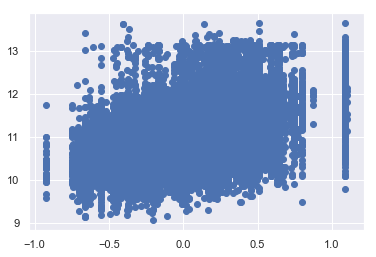

In [129]:
plt.scatter(np.array(X_finaltest) @ np.array(coefs[0]['pd'].mean()),y_finaltest)

In [144]:
lsa(X,y)

Arm-Hand Steadiness              0.110664
Auditory Attention              -0.015386
Category Flexibility            -0.041602
Control Precision               -0.051044
Deductive Reasoning             -0.037729
Depth Perception                 0.055696
Dynamic Flexibility             -0.024638
Dynamic Strength                -0.013054
Explosive Strength              -0.004460
Extent Flexibility              -0.028162
Far Vision                       0.001093
Finger Dexterity                -0.061598
Flexibility of Closure          -0.015422
Fluency of Ideas                -0.063039
Glare Sensitivity                0.110509
Gross Body Coordination          0.066888
Gross Body Equilibrium          -0.050564
Hearing Sensitivity             -0.101493
Inductive Reasoning              0.189064
Information Ordering             0.052714
Manual Dexterity                -0.065305
Mathematical Reasoning          -0.027686
Memorization                    -0.020268
Multilimb Coordination           0

In [ ]:
y_pred = pd.DataFrame((X_test @ fit.T.iloc[-1]),index = X_test.index)
y_pred['y_test'] = y_test

In [ ]:
y_pred['diff'] = y_pred[0] - y_pred['y_test']
rmsqe = np.sqrt(sum(y_pred['diff'].apply(np.square))/len(y_pred))
rmsqe

In [ ]:
y_test

In [ ]:
plf(dkn,4)

In [18]:
dab_pop0 = plo_fte(dab,2,0).index

In [34]:
Svd(matrix(dab).loc[dab_pop0]).f.apply(np.square).T[0].plot.bar(0)

TypeError: bar() takes 1 positional argument but 2 were given

In [ ]:
 fitdata = plo_FTE(dab,2,1).merge(X_raw,left_index=True,right_index=True)

In [13]:
svab = Svd(matrix(dab))

In [182]:
dab

,O*NET-SOC Code,Element Name,Data Value
1,11-1011.00,Oral Comprehension,4.88
3,11-1011.00,Written Comprehension,4.62
5,11-1011.00,Oral Expression,5.00
7,11-1011.00,Written Expression,4.62
9,11-1011.00,Fluency of Ideas,4.62
11,11-1011.00,Originality,4.25
13,11-1011.00,Problem Sensitivity,5.00
15,11-1011.00,Deductive Reasoning,5.00
17,11-1011.00,Inductive Reasoning,5.00
19,11-1011.00,Information Ordering,4.00


In [184]:
from_onet('Abilities')[:50]

,O*NET-SOC Code,Title,Element ID,Element Name,Scale ID,Scale Name,Data Value,N,Standard Error,Lower CI Bound,Upper CI Bound,Recommend Suppress,Not Relevant,Date,Domain Source
0,11-1011.00,Chief Executives,1.A.1.a.1,Oral Comprehension,IM,Importance,4.50,8.0,0.19,4.13,4.87,N,NaN,07/2014,Analyst
1,11-1011.00,Chief Executives,1.A.1.a.1,Oral Comprehension,LV,Level,4.88,8.0,0.13,4.63,5.12,N,N,07/2014,Analyst
2,11-1011.00,Chief Executives,1.A.1.a.2,Written Comprehension,IM,Importance,4.25,8.0,0.16,3.93,4.57,N,NaN,07/2014,Analyst
3,11-1011.00,Chief Executives,1.A.1.a.2,Written Comprehension,LV,Level,4.62,8.0,0.18,4.27,4.98,N,N,07/2014,Analyst
4,11-1011.00,Chief Executives,1.A.1.a.3,Oral Expression,IM,Importance,4.38,8.0,0.18,4.02,4.73,N,NaN,07/2014,Analyst
5,11-1011.00,Chief Executives,1.A.1.a.3,Oral Expression,LV,Level,5.00,8.0,0.00,5.00,5.00,N,N,07/2014,Analyst
6,11-1011.00,Chief Executives,1.A.1.a.4,Written Expression,IM,Importance,4.12,8.0,0.13,3.88,4.37,N,NaN,07/2014,Analyst
7,11-1011.00,Chief Executives,1.A.1.a.4,Written Expression,LV,Level,4.62,8.0,0.18,4.27,4.98,N,N,07/2014,Analyst
8,11-1011.00,Chief Executives,1.A.1.b.1,Fluency of Ideas,IM,Importance,3.88,8.0,0.13,3.63,4.12,N,NaN,07/2014,Analyst
9,11-1011.00,Chief Executives,1.A.1.b.1,Fluency of Ideas,LV,Level,4.62,8.0,0.18,4.27,4.98,N,N,07/2014,Analyst


Text(0.5,1,'O*NET DATABASE')

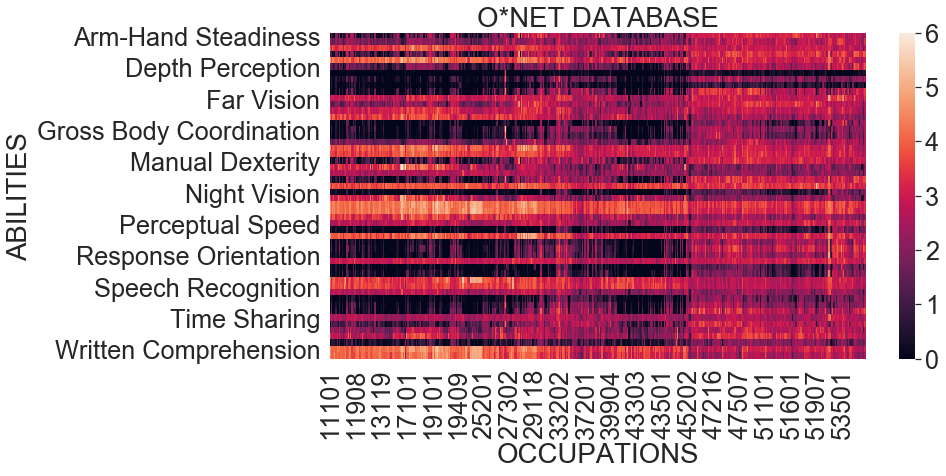

In [193]:
sns.set(color_codes=True)
sns.set(font_scale=2.3) 
f, axes = plt.subplots(1,1, sharey=True, figsize=(12, 6))
sns.heatmap(matrix(dab).T)
plt.xlabel('OCCUPATIONS')
plt.ylabel('ABILITIES')
plt.title('O*NET DATABASE')